In [52]:
!pip install pyspark

In [53]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("spark customer segmentation") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [54]:
df = spark.read.format('com.databricks.spark.csv').options(header ='true', inferschema = 'true').load('/content/drive/MyDrive/Colab Notebooks/Spark/phân loại khách hàng với spark/Train.csv',header = True)
df.show()

+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+
|    ID|Gender|Ever_Married|Age|Graduated|   Profession|Work_Experience|Spending_Score|Family_Size|Var_1|Segmentation|
+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+
|462809|  Male|          No| 22|       No|   Healthcare|            1.0|           Low|        4.0|Cat_4|           D|
|462643|Female|         Yes| 38|      Yes|     Engineer|           null|       Average|        3.0|Cat_4|           A|
|466315|Female|         Yes| 67|      Yes|     Engineer|            1.0|           Low|        1.0|Cat_6|           B|
|461735|  Male|         Yes| 67|      Yes|       Lawyer|            0.0|          High|        2.0|Cat_6|           B|
|462669|Female|         Yes| 40|      Yes|Entertainment|           null|          High|        6.0|Cat_6|           A|
|461319|  Male|         Yes| 56|       No|      

In [55]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Ever_Married: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Graduated: string (nullable = true)
 |-- Profession: string (nullable = true)
 |-- Work_Experience: double (nullable = true)
 |-- Spending_Score: string (nullable = true)
 |-- Family_Size: double (nullable = true)
 |-- Var_1: string (nullable = true)
 |-- Segmentation: string (nullable = true)



In [56]:
df.columns

['ID',
 'Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation']

In [57]:
from pyspark.sql.functions import col

columns_to_check = df.columns

for col_name in columns_to_check:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"Column '{col_name}' has {null_count} null value(s).")

    if "Age" in col_name or "Family_Size" in col_name or "Work_Experience" in col_name:
        df = df.fillna({col_name: 0})
    else:
        df = df.fillna({col_name: "Unknown"})

df.show()

Column 'ID' has 0 null value(s).
Column 'Gender' has 0 null value(s).
Column 'Ever_Married' has 140 null value(s).
Column 'Age' has 0 null value(s).
Column 'Graduated' has 78 null value(s).
Column 'Profession' has 124 null value(s).
Column 'Work_Experience' has 829 null value(s).
Column 'Spending_Score' has 0 null value(s).
Column 'Family_Size' has 335 null value(s).
Column 'Var_1' has 76 null value(s).
Column 'Segmentation' has 0 null value(s).
+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+
|    ID|Gender|Ever_Married|Age|Graduated|   Profession|Work_Experience|Spending_Score|Family_Size|Var_1|Segmentation|
+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+
|462809|  Male|          No| 22|       No|   Healthcare|            1.0|           Low|        4.0|Cat_4|           D|
|462643|Female|         Yes| 38|      Yes|     Engineer|            0.0|  

In [58]:
from pyspark.ml.feature import StringIndexer

In [59]:
df_r = StringIndexer(inputCols=['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1'],
                        outputCols=['Gender_index','Ever_Married_index','Graduated_index','Profession_index',
                                    'Spending_Score_index','Var_1_index']).fit(df).transform(df)

df_r.show(5)

+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+------------+------------------+---------------+----------------+--------------------+-----------+
|    ID|Gender|Ever_Married|Age|Graduated|   Profession|Work_Experience|Spending_Score|Family_Size|Var_1|Segmentation|Gender_index|Ever_Married_index|Graduated_index|Profession_index|Spending_Score_index|Var_1_index|
+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+------------+------------------+---------------+----------------+--------------------+-----------+
|462809|  Male|          No| 22|       No|   Healthcare|            1.0|           Low|        4.0|Cat_4|           D|         0.0|               1.0|            1.0|             1.0|                 0.0|        1.0|
|462643|Female|         Yes| 38|      Yes|     Engineer|            0.0|       Average|        3.0|Cat_4|           A|         1.0| 

In [60]:
df_r.columns

['ID',
 'Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Profession',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Var_1',
 'Segmentation',
 'Gender_index',
 'Ever_Married_index',
 'Graduated_index',
 'Profession_index',
 'Spending_Score_index',
 'Var_1_index']

In [61]:
output_r = StringIndexer(inputCol='Segmentation',outputCol='index_label').fit(df_r).transform(df_r)
output_r.show(5)

+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+------------+------------------+---------------+----------------+--------------------+-----------+-----------+
|    ID|Gender|Ever_Married|Age|Graduated|   Profession|Work_Experience|Spending_Score|Family_Size|Var_1|Segmentation|Gender_index|Ever_Married_index|Graduated_index|Profession_index|Spending_Score_index|Var_1_index|index_label|
+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+------------+------------------+---------------+----------------+--------------------+-----------+-----------+
|462809|  Male|          No| 22|       No|   Healthcare|            1.0|           Low|        4.0|Cat_4|           D|         0.0|               1.0|            1.0|             1.0|                 0.0|        1.0|        0.0|
|462643|Female|         Yes| 38|      Yes|     Engineer|            0.0|       Avera

In [62]:
from pyspark.ml.feature import VectorAssembler

output = VectorAssembler(inputCols=['Gender_index', 'Ever_Married_index', 'Age', 'Graduated_index',
                                               'Profession_index', 'Work_Experience', 'Spending_Score_index',
                                               'Family_Size', 'Var_1_index'],
                                    outputCol='feature',
                                    handleInvalid="keep").transform(output_r)


In [63]:
output.select('feature').show()

+--------------------+
|             feature|
+--------------------+
|[0.0,1.0,22.0,1.0...|
|[1.0,0.0,38.0,0.0...|
|[1.0,0.0,67.0,0.0...|
|(9,[2,4,6,7],[67....|
|[1.0,0.0,40.0,0.0...|
|(9,[2,3,6,7],[56....|
|[0.0,1.0,32.0,0.0...|
|[1.0,1.0,33.0,0.0...|
|[1.0,0.0,61.0,0.0...|
|[1.0,0.0,55.0,0.0...|
|[1.0,1.0,26.0,0.0...|
|[0.0,1.0,19.0,1.0...|
|[1.0,1.0,19.0,1.0...|
|(9,[2,3,4,7],[70....|
|[1.0,0.0,58.0,1.0...|
|[1.0,1.0,41.0,1.0...|
|[1.0,1.0,32.0,1.0...|
|[0.0,1.0,31.0,1.0...|
|[0.0,0.0,58.0,0.0...|
|(9,[0,2,6,7],[1.0...|
+--------------------+
only showing top 20 rows



In [64]:
final_data = output.select('feature','index_label')
final_data.show()

+--------------------+-----------+
|             feature|index_label|
+--------------------+-----------+
|[0.0,1.0,22.0,1.0...|        0.0|
|[1.0,0.0,38.0,0.0...|        1.0|
|[1.0,0.0,67.0,0.0...|        3.0|
|(9,[2,4,6,7],[67....|        3.0|
|[1.0,0.0,40.0,0.0...|        1.0|
|(9,[2,3,6,7],[56....|        2.0|
|[0.0,1.0,32.0,0.0...|        2.0|
|[1.0,1.0,33.0,0.0...|        0.0|
|[1.0,0.0,61.0,0.0...|        0.0|
|[1.0,0.0,55.0,0.0...|        2.0|
|[1.0,1.0,26.0,0.0...|        1.0|
|[0.0,1.0,19.0,1.0...|        0.0|
|[1.0,1.0,19.0,1.0...|        0.0|
|(9,[2,3,4,7],[70....|        1.0|
|[1.0,0.0,58.0,1.0...|        3.0|
|[1.0,1.0,41.0,1.0...|        2.0|
|[1.0,1.0,32.0,1.0...|        0.0|
|[0.0,1.0,31.0,1.0...|        3.0|
|[0.0,0.0,58.0,0.0...|        3.0|
|(9,[0,2,6,7],[1.0...|        2.0|
+--------------------+-----------+
only showing top 20 rows



In [65]:
(trainingData, testData) = final_data.randomSplit([0.8, 0.2])
trainingData.show(5)
testData.show(5)

+--------------------+-----------+
|             feature|index_label|
+--------------------+-----------+
|(9,[0,1,2],[1.0,1...|        3.0|
|(9,[0,1,2],[1.0,1...|        3.0|
|(9,[0,1,2,3],[1.0...|        2.0|
|(9,[0,1,2,4],[1.0...|        0.0|
|(9,[0,1,2,4],[1.0...|        0.0|
+--------------------+-----------+
only showing top 5 rows

+--------------------+-----------+
|             feature|index_label|
+--------------------+-----------+
|(9,[0,1,2],[1.0,1...|        1.0|
|(9,[0,1,2,4],[1.0...|        0.0|
|(9,[0,1,2,5],[1.0...|        1.0|
|(9,[0,1,2,7],[1.0...|        1.0|
|(9,[0,1,2,7],[1.0...|        1.0|
+--------------------+-----------+
only showing top 5 rows



In [72]:

from pyspark.ml.classification import DecisionTreeClassifier

dTree = DecisionTreeClassifier(labelCol='index_label', featuresCol='feature')

In [73]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[dTree])

# Fit the pipeline to the training data
model = pipeline.fit(output)

In [82]:
predictions = model.transform(testData)
predictions.show()

+--------------------+-----------+--------------------+--------------------+----------+
|             feature|index_label|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(9,[0,1,2],[1.0,1...|        1.0|[53.0,115.0,35.0,...|[0.21544715447154...|       1.0|
|(9,[0,1,2,4],[1.0...|        0.0|[190.0,59.0,25.0,...|[0.65517241379310...|       0.0|
|(9,[0,1,2,5],[1.0...|        1.0|[84.0,396.0,273.0...|[0.07041072925398...|       3.0|
|(9,[0,1,2,7],[1.0...|        1.0|[53.0,115.0,35.0,...|[0.21544715447154...|       1.0|
|(9,[0,1,2,7],[1.0...|        1.0|[53.0,115.0,35.0,...|[0.21544715447154...|       1.0|
|(9,[0,1,2,7],[1.0...|        1.0|[53.0,115.0,35.0,...|[0.21544715447154...|       1.0|
|(9,[0,1,2,7],[1.0...|        1.0|[53.0,115.0,35.0,...|[0.21544715447154...|       1.0|
|(9,[0,1,2,7],[1.0...|        3.0|[84.0,396.0,273.0...|[0.07041072925398...|       3.0|
|(9,[0,1,2,7],[1.0...|        2.

In [ ]:
predictions.select("feature","index_label","prediction").show(5)

In [78]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
labelCol="index_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.487774


In [87]:
class_temp = predictions.select("index_label").groupBy("index_label").count().sort('count', ascending=False).toPandas()

class_temp = class_temp["index_label"].values.tolist()
class_names = list(map(str, class_temp))
print(class_names)

['0.0', '1.0', '2.0', '3.0']


In [90]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [91]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("index_label").toPandas()
y_pred = predictions.select("prediction").toPandas()

y_true = y_true["index_label"].astype(int)
y_pred = y_pred["prediction"].astype(int)

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
print(cnf_matrix)

[[319  79   6  41]
 [ 84 133  23 147]
 [ 66  23 182 111]
 [ 58  58  82 183]]


Confusion matrix, without normalization
[[319  79   6  41]
 [ 84 133  23 147]
 [ 66  23 182 111]
 [ 58  58  82 183]]


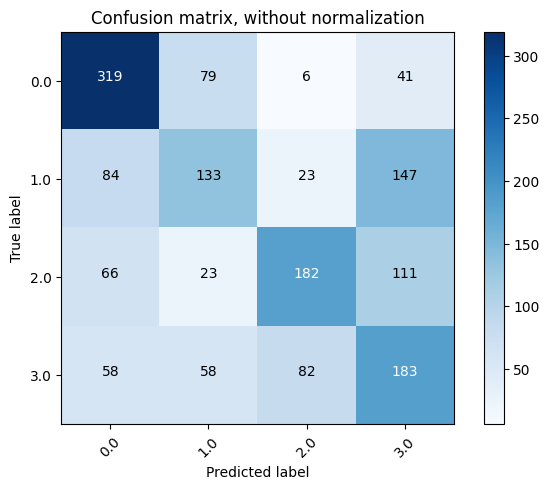

In [92]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,

title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[0.71685393 0.17752809 0.01348315 0.09213483]
 [0.21705426 0.34366925 0.05943152 0.37984496]
 [0.17277487 0.06020942 0.47643979 0.29057592]
 [0.15223097 0.15223097 0.2152231  0.48031496]]


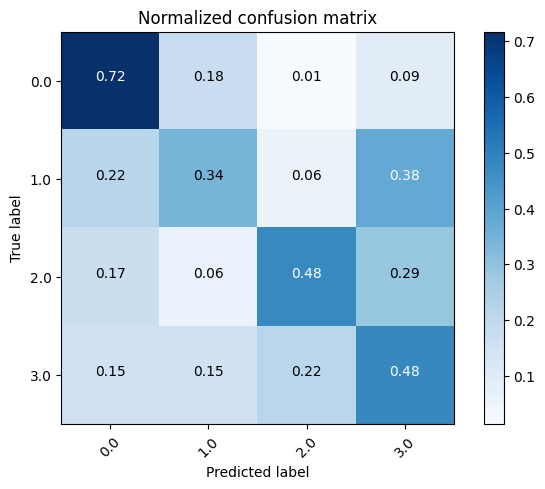

In [93]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,

title='Normalized confusion matrix')

plt.show()